# EN->DE Translation Demo

This notebook loads `checkpoints/translation/best.pt` and runs greedy decoding with the trained Transformer.

In [24]:
from __future__ import annotations

import re
import sys
from dataclasses import asdict
from pathlib import Path

import torch

ROOT_DIR = Path.cwd()
if not (ROOT_DIR / 'transformer.py').exists():
    ROOT_DIR = ROOT_DIR.parent.parent
if str(ROOT_DIR) not in sys.path:
    sys.path.append(str(ROOT_DIR))

from tasks.translation.dataset import BOS_TOKEN, EOS_TOKEN, PAD_TOKEN, UNK_TOKEN, Vocabulary, basic_tokenize
from transformer import OriginalTransformer, TransformerConfig

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cpu


In [25]:
ckpt_path = ROOT_DIR / 'checkpoints' / 'translation' / 'best.pt'
if not ckpt_path.exists():
    raise FileNotFoundError(f'Checkpoint not found: {ckpt_path}')

checkpoint = torch.load(ckpt_path, map_location=device)

src_vocab = Vocabulary(stoi=checkpoint['src_vocab_stoi'], itos=checkpoint['src_vocab_itos'])
tgt_vocab = Vocabulary(stoi=checkpoint['tgt_vocab_stoi'], itos=checkpoint['tgt_vocab_itos'])
cfg = TransformerConfig(**checkpoint['cfg'])
tie_weights = bool(checkpoint.get('args', {}).get('tie_weights', False))

model = OriginalTransformer(
    src_vocab_size=len(src_vocab),
    tgt_vocab_size=len(tgt_vocab),
    cfg=cfg,
    tie_weights=tie_weights,
).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print('loaded checkpoint:', ckpt_path)
print('epoch:', checkpoint.get('epoch'))
print('val_loss:', checkpoint.get('val_loss'))
print('src_vocab:', len(src_vocab), 'tgt_vocab:', len(tgt_vocab))
print('model_cfg:', asdict(cfg))

loaded checkpoint: /Users/chen/Documents/Code/transformer-app/checkpoints/translation/best.pt
epoch: 57
val_loss: 4.049867573835491
src_vocab: 697 tgt_vocab: 735
model_cfg: {'d_model': 256, 'num_heads': 8, 'd_ff': 1024, 'num_layers': 4, 'dropout': 0.2, 'pre_ln': False, 'pos_type': 'sinusoidal', 'max_len': 130}


In [26]:
def _cleanup_text(text: str) -> str:
    text = re.sub(r'\s+([,.!?;:])', r'\1', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def encode_source(text: str) -> torch.Tensor:
    tokens = basic_tokenize(text)
    token_ids = src_vocab.encode(tokens, add_bos=True, add_eos=True)
    return torch.tensor(token_ids, dtype=torch.long, device=device).unsqueeze(0)

def decode_target(token_ids: list[int]) -> str:
    tokens = []
    for tid in token_ids:
        if tid in {tgt_vocab.bos_id, tgt_vocab.pad_id}:
            continue
        if tid == tgt_vocab.eos_id:
            break
        tokens.append(tgt_vocab.itos[tid] if 0 <= tid < len(tgt_vocab) else UNK_TOKEN)
    return _cleanup_text(' '.join(tokens))

@torch.no_grad()
def translate_greedy(text: str, max_new_tokens: int = 80) -> str:
    src_ids = encode_source(text)
    src_key_padding_mask = src_ids.eq(src_vocab.pad_id)

    generated = [tgt_vocab.bos_id]
    for _ in range(max_new_tokens):
        tgt_in = torch.tensor(generated, dtype=torch.long, device=device).unsqueeze(0)
        tgt_key_padding_mask = tgt_in.eq(tgt_vocab.pad_id)

        logits = model(
            src=src_ids,
            tgt=tgt_in,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
        )
        next_id = int(logits[0, -1].argmax().item())
        generated.append(next_id)
        if next_id == tgt_vocab.eos_id:
            break

    return decode_target(generated)

def show_translation(text: str) -> None:
    print('EN:', text)
    print('DE:', translate_greedy(text))
    print('-' * 80)

In [27]:
examples = [
    'The cat sits on the mat.',
    'I love learning about machine translation.',
    'This model was trained on IWSLT data.',
]

for sentence in examples:
    show_translation(sentence)

EN: The cat sits on the mat.
DE: die <unk> <unk> <unk> die <unk>.
--------------------------------------------------------------------------------
EN: I love learning about machine translation.
DE: ich werde ich werde ich werde <unk> <unk> <unk>.
--------------------------------------------------------------------------------
EN: This model was trained on IWSLT data.
DE: diese <unk> <unk> also in einem <unk>.
--------------------------------------------------------------------------------


In [28]:
# Try your own sentence:
show_translation('Then CEAS applies the generator to the four labeled documents independently and generates release notes for each class.')

EN: Then CEAS applies the generator to the four labeled documents independently and generates release notes for each class.
DE: dann die <unk> <unk> für die klasse und die <unk> für jede klasse <unk> für jede klasse.
--------------------------------------------------------------------------------


## Training Loss Visualization

Plot train/validation loss from `checkpoints/translation/metrics.csv` (or fallback to checkpoint history).

Loaded metrics from /Users/chen/Documents/Code/transformer-app/checkpoints/translation/metrics.csv


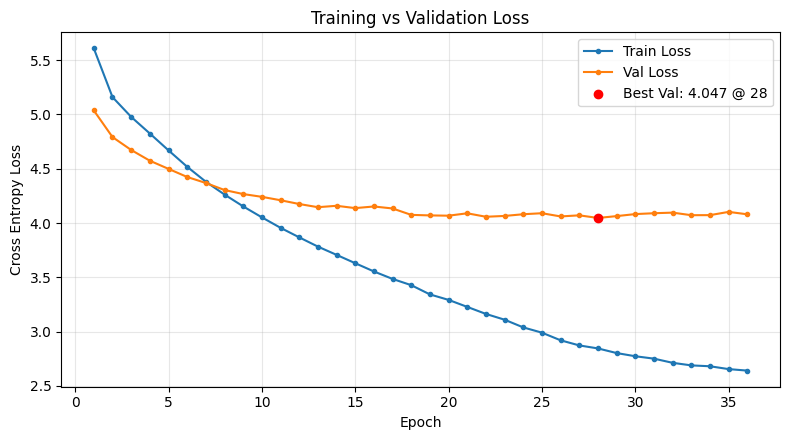

In [31]:
import csv
import matplotlib.pyplot as plt

metrics_path = ROOT_DIR / 'checkpoints' / 'translation' / 'metrics.csv'
epochs, train_loss, val_loss = [], [], []

if metrics_path.exists():
    with metrics_path.open('r', encoding='utf-8', newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            epochs.append(int(row['epoch']))
            train_loss.append(float(row['train_loss']))
            val_loss.append(float(row['val_loss']))
    print('Loaded metrics from', metrics_path)
else:
    hist = checkpoint.get('history', {})
    train_loss = hist.get('train_loss', [])
    val_loss = hist.get('val_loss', [])
    epochs = list(range(1, len(train_loss) + 1))
    print('Loaded metrics from checkpoint history')

if not epochs:
    raise RuntimeError('No metrics found. Re-run training with updated train.py to save metrics.')

plt.figure(figsize=(8, 4.5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o', linewidth=1.5, markersize=3)
plt.plot(epochs, val_loss, label='Val Loss', marker='o', linewidth=1.5, markersize=3)
best_epoch = epochs[val_loss.index(min(val_loss))]
best_val = min(val_loss)
plt.scatter([best_epoch], [best_val], color='red', zorder=3, label=f'Best Val: {best_val:.3f} @ {best_epoch}')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Training vs Validation Loss')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
